# 火炬上的深度学习（下）第四节：彩云小译

## 课后作业：实现一个「英翻中」的翻译模型，并评估效果

实现后的模型希望能够达到这种效果：

```
> en2cn("Unbalanced development is one of china s successful experiences over the past years.")
不平衡 发展 是 我国 最近 20 年 的 成功 经验 之一 .
```

#### 设计与目标

* 实现注意力模型；
* 使用SRU的神经元；
* 实现Beam Search算法来计算输出结果；
* 实现「中翻英」，评估多次翻译后结果；

In [42]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
import torch.utils.data as DataSet

# SRU包
# 参照：https://github.com/taolei87/sru
from sru import SRU, SRUCell

# 绘图所用的包
import matplotlib.pyplot as plt
import numpy as np


# 尝试使用GPU
use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
itype = torch.cuda.LongTensor if use_cuda else torch.LongTensor

# 即时绘图
%matplotlib inline

## 数据准备

这里希望能够通过一定的封装来在不同的数据集上训练模型。因此希望能够做到在选用「对照数据集」和给定「句子长度限制」后得到可供模型使用的训练集、校验集、测试集。

In [43]:
import re
from io import open
import unicodedata
import string
import jieba
import random

class Lang:
    SOS = 0
    EOS = 1
    
    def __init__(self, name):
        self.name = name
        self.wordNumb = 2
        # 这里没有使用list结构，因为SOS与EOS为非可见的控制字符，防止与文本中的SOS或者EOS混淆
        self.idx2word = {Lang.SOS:'SOS', Lang.EOS:'EOS'}
        self.word2idx = {}
        self.wordFreq = {}
        
    def addWord(self, word):
        if word in self.word2idx:
            self.wordFreq[word] += 1
        else:
            self.idx2word[self.wordNumb]=word
            self.word2idx[word]=self.wordNumb
            self.wordFreq[word]=1
            self.wordNumb += 1
            
    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)
            
    def word2index(self, word):
        if word not in self.word2idx:
            self.addWord(word)
        return self.word2idx[word];
    
    def sen2indexes(self, sentence):
        return [self.word2index(w) for w in sentence.split(' ')]
    
    def index2word(self, index):
        return self.idx2word[index] if index > 0 and index < self.wordNumb else ''
    
    def indexes2sen(self, indexes):
        return ' '.join([self.index2word(i) for i in indexes if i != Lang.EOS])
    
    def wordNum(self):
        return self.wordNumb
        


class LangData:
    
    def __init__(self, chinese_file, english_file, encoding='utf-8', cut_chinese=False):
        chinese = open(chinese_file,'r',encoding=encoding).read().strip().split('\n')
        if cut_chinese:
            self.chinese = [self.cutChinese(s) for s in chinese]
        else:
            self.chinese = chinese
        
        english = open(english_file,'r',encoding=encoding).read().strip().split('\n')
        self.english = [self.normalizeEnglish(s) for s in english]

           
    # Turn a Unicode string to plain ASCII, thanks to
    # http://stackoverflow.com/a/518232/2809427
    # 将unicode编码转变为ascii编码
    def u2a(self, s):
        return ''.join(
            c for c in unicodedata.normalize('NFD', s)
            if unicodedata.category(c) != 'Mn'
        )
    
    def normalizeEnglish(self, s):
        s = self.u2a(s)
        s = re.sub(r"(\W)", r" \1",s)
        s = re.sub(r"[^a-zA-Z0-9_,\.\!\?]+", r" ", s)
        s = s.lower().strip()
        return s
    
    def cutChinese(self, s):
        return " ".join(jieba.cut(s))
    
    def _toIndex(self, l, s, n):
        idx = l.sen2indexes(s)
        for i in range(n - len(idx)):
            idx.append(Lang.EOS)
        return idx
    
    def getDataLoader(self, sen_length, batch_size, target='cn'):
        # 构造语言对，并打乱
        pairs = [p 
                 for p in zip(self.chinese, self.english) 
                 if (len(p[0].split(' ')) < sen_length and len(p[1].split(' ')) < sen_length)]
        
        random.shuffle(pairs)
                
        # 建立词索引
        Chinese, English = Lang('Chinese'), Lang('English')
        for c,e in pairs:
            Chinese.addSentence(c)
            English.addSentence(e)

        # 文本变为索引，并且扩展为等长长度
        pairs = [(self._toIndex(Chinese,p[0],sen_length), self._toIndex(English,p[1],sen_length)) for p in pairs]

        xi,yi = (1,0) if target=='cn' else (0,1)
        
        # 形成训练集、校验集和测试集
        valid_size = len(pairs) // 10
        if valid_size > 10000:
            valid_size = 10000
            
        train = torch.LongTensor(pairs[ : -valid_size])
        valid = torch.LongTensor(pairs[-valid_size : -valid_size // 2])
        test  = torch.LongTensor(pairs[-valid_size // 2 :])
        
        # 形成训练集
        trainSet = DataSet.TensorDataset(train[:,xi], train[:,yi])
        trainLoader = DataSet.DataLoader(trainSet, batch_size = batch_size, shuffle=True, num_workers=8)
        # 校验数据
        validSet = DataSet.TensorDataset(valid[:,xi], valid[:,yi])
        validLoader = DataSet.DataLoader(validSet, batch_size = batch_size, shuffle=True, num_workers=8)
        # 测试数据
        testSet = DataSet.TensorDataset(test[:,xi], test[:,yi])
        testLoader = DataSet.DataLoader(testSet, batch_size = batch_size, shuffle=True, num_workers=8)
        
        print('有效句子对：{}\n训练记录：{}\n校验记录：{}\n测试记录：{}'
              .format(len(pairs),len(trainSet),len(validSet),len(testSet)))
        
        return trainLoader, validLoader, testLoader, Chinese, English

## 读取数据

这里得到得到训练集、验证集、测试集以及语言模型

In [20]:
langData=LangData('data/chinese.txt','data/english.txt')

print('中文句子总数：{}\n英文句子总数：{}'.format(len(langData.chinese),len(langData.english)))

中文句子总数：100000
英文句子总数：100000


In [44]:
MAX_LENGTH = 16
train, valid, test, Chi, Eng = langData.getDataLoader(MAX_LENGTH, batch_size = 30, target='cn')

print("总单词数：\n  CH: {}\n  EN: {}".format(Chi.wordNum(),Eng.wordNum()))

有效句子对：9621
训练记录：8659
校验记录：481
测试记录：481
总单词数：
  CH: 11225
  EN: 9185


## 搭建神经网络

搭建基于AM模型的神经网络，编码器与解码器都使用SRU作为激活单元

### 编码器

In [22]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1, core='sru'):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.is_sru = core == 'sru'
        
        self.embedding = nn.Embedding(input_size, hidden_size)

        if self.is_sru:
            self.rnn = SRU(hidden_size, hidden_size,
                num_layers = n_layers,          # number of stacking RNN layers
                dropout = 0.0,           # dropout applied between RNN layers
                rnn_dropout = 0.0,       # variational dropout applied on linear transformation
                use_tanh = 0,         # use tanh?
                use_relu = 0,            # use ReLU?
                bidirectional = True    # bidirectional RNN ?
            )
        else:
            self.rnn = nn.GRU(hidden_size, hidden_size, num_layers = n_layers, bidirectional = True)

    def forward(self, input, hidden):
        # input尺寸： batch_size, length_seq
        # embedded尺寸：batch_size, length_seq, hidden_size
        embedded = self.embedding(input)
        
        # embedded转成：seq_size, batch_size, hidden_size
        input = embedded.transpose(0,1).contiguous()
        
        output, hidden = self.rnn(input, hidden)

        # output转为：batch_size, length_seq, hidden_size
        output = output.transpose(0,1).contiguous()
        
        # hidden：num_layers, batch_size, hidden_size * directions
        return output, hidden

    def initHidden(self, batch_size):
        if self.is_sru:
            return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size * 2).type(dtype))
        else:
            return Variable(torch.zeros(self.n_layers * 2, batch_size, self.hidden_size).type(dtype))

### 解码器

In [47]:
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, attn_size, n_layers=1, dropout_p=0.1, core='sru'):
        super(Decoder, self).__init__()
        self.is_sru = core == 'sru'

        # 词嵌入层
        self.embedding = nn.Embedding(output_size, hidden_size)
        
        # 注意力网络（一个前馈神经网络）
        self.attn = nn.Linear(hidden_size * (2 * n_layers + 1), attn_size)
    
        # 注意力机制作用完后的结果映射到后面的层
        self.attn_combine = nn.Linear(hidden_size * 3, hidden_size)
        
        # dropout操作层
        self.dropout = nn.Dropout(dropout_p)
        
        if self.is_sru:
            self.rnn = SRU(hidden_size, hidden_size,
                num_layers = n_layers,          # number of stacking RNN layers
                dropout = dropout_p,           # dropout applied between RNN layers
                rnn_dropout = dropout_p,       # variational dropout applied on linear transformation
                use_tanh = 0,         # use tanh?
                use_relu = 0,            # use ReLU?
                bidirectional = True    # bidirectional RNN ?
            )
        else:
            self.rnn = nn.GRU(hidden_size, hidden_size, num_layers = n_layers, bidirectional = True)
            
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, input, hidden, encoder_outputs):
        # input大小：batch_size, length_seq=1
        # hidden大小：n_layer, batch_size, hidden_size*direction
        
        # embedded大小：batch_size, length_seq, hidden_size
        embedded = self.embedding(input)
        # embedded大小：batch_size, hidden_size
        embedded = embedded[:, 0, :]
        embedded = self.dropout(embedded)
        
        # 将hidden张量数据转化成batch_size排在第0维的形状
        attn_input_hidden = hidden.transpose(0, 1).contiguous()
        # hidden_attn大小：batch_size, direction*n_layers*hidden_size
        attn_input_hidden = attn_input_hidden.view(attn_input_hidden.size(0), -1)
        
        # attn_input：batch_size, hidden_size * (1 + direction * n_layers)
        attn_input = torch.cat((embedded, attn_input_hidden), 1)
        
        # 注意力层输出的权重
        # attn_weights大小：batch_size, max_length
        attn_weights = F.softmax(self.attn(attn_input))
        
        # 当输入数据不标准的时候，对weights截取必要的一段
        # attn_weights大小：batch_size, length_seq_of_encoder
        attn_weights = attn_weights[:, : encoder_outputs.size(1)]
        # attn_weights大小：batch_size, 1, length_seq 中间的1是为了bmm乘法用的
        attn_weights = attn_weights.unsqueeze(1)
        
        # 将attention的weights矩阵乘encoder_outputs以计算注意力完的结果
        # encoder_outputs大小：batch_size, seq_length, hidden_size * 2
        # attn_applied大小：batch_size, 1, hidden_size * 2
        attn_applied = torch.bmm(attn_weights, encoder_outputs) 
        
        # 将输入的词向量与注意力机制作用后的结果拼接成一个大的输入向量
        # output大小：batch_size, hidden_size * (direction + 1)
        to_combine = torch.cat((embedded, attn_applied[:,0,:]), 1)
        
        # 将大输入向量映射为GRU的输入向量
        # input：batch_size, 1, hidden_size
        input = self.attn_combine(to_combine).unsqueeze(1)
        
        input = F.relu(input)
        input = self.dropout(input)

        # 开始解码器SRU的运算
        # output大小：length_seq, batch_size, hidden_size * directions
        # hidden大小：n_layers, batch_size, hidden_size * directions
        input = input.transpose(0, 1).contiguous()
        output, hidden = self.rnn(input, hidden)
        
        # output大小：batch_size * output_size
        output = self.fc(output[-1, :, :])
        
        output = F.log_softmax(output)

        return output, hidden, attn_weights
    
    
    def initInput(self, batch_size):
        return Variable(torch.LongTensor([[Lang.SOS]] * batch_size).type(itype))


## 准备训练

In [126]:
import time
import math

def time_since(t):
    now = time.time()
    s = now - t
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def rightness(output, labels):
    # predictions: batch, max_length, class_num
#     y = torch.max(predictions.data, 1)[1]
    rights = output.eq(labels.data).sum()
    return rights, labels.numel()

def beam_search(bn, decoder, input, hidden, encoder_outputs, max_length=MAX_LENGTH, debug=True):
    batch_num = input.size(0)

    # 执行第一步beam_search
    decoder_output, hidden, attn = decoder(input, hidden, encoder_outputs)
    topv, topi = decoder_output.data.topk(bn, 1)
    
    # 权重w存储每个baam的权重和：batch, bn
    w = topv
    # output: batch, bn, max_length
    outputs = (topi.cpu() if use_cuda else topi).unsqueeze(2)
     
    # hiddens: bn, ...
    hidden = hidden.unsqueeze(0)
    hiddens = hidden.clone()
    for i in range(1, bn):
        hiddens = torch.cat((hiddens, hidden.clone()), 0)
    
    # attns: batch, bn, max_length, max_length
    attn = attn.unsqueeze(1).data
    attns = attn.clone()
    for i in range(1, bn):
        attns = torch.cat((attns, attn.clone()), 1)
        
    if debug:
        print('---0---')
        print("\n".join(["({:.4f}) {:s}".format(w[0,i], Chi.indexes2sen(outputs[0,i,:].numpy())) for i in range(bn)]))
    
    # 循环执行后续步骤
    for si in range(1, max_length):
        # b_w: batch, bn*class_num
        b_w=torch.FloatTensor().type(dtype)
        b_a=torch.FloatTensor().type(dtype)
        
        for bi in range(bn):
            input = Variable(outputs[:,bi,-1].unsqueeze(1)).type(itype)
            decoder_output, hiddens[bi], attn = decoder(input, hiddens[bi,...], encoder_outputs)
#             print(w[:,bi].size(), decoder_output.data.size())
            b_w = torch.cat((b_w, (w[:,bi].unsqueeze(1) + decoder_output.data)), 1)
            b_a = torch.cat((b_a, attn.unsqueeze(1).data), 1)
        
        n = decoder_output.size(1)
        topv, topi = b_w.topk(bn, 1)
        w = topv
        
        # 拼接结果
        _o = outputs.numpy().tolist()
        outputs = []
        for i in range(batch_num):
            _bn = []
            for j in range(bn):
                t = _o[i][topi[i, j] // n][:] if si!=0 else []
                t.append(topi[i, j] % n)
                _bn.append(t)
            outputs.append(_bn)
        outputs = torch.LongTensor(outputs)
        attns = torch.cat((attns, b_a), 2)
        
        if debug:
            print('---{}---'.format(si))
            print("\n".join(["({:.4f}) {:s}".format(w[0,i], Chi.indexes2sen(outputs[0,i,:].numpy())) for i in range(bn)]))

    maxwi = w.max(1)[1]
    outputs = outputs.numpy()
    attns = (attns.cpu() if use_cuda else attns).numpy()
    output = [outputs[i][maxwi[i]] for i in range(batch_num)]
    attn = [attns[i][maxwi[i]] for i in range(batch_num)]
    
    return output, attn, outputs, attns, w

def evaluate(sentence, encoder, decoder, bn=3,  max_length=MAX_LENGTH , beam=True, debug=False):
    if sentence.dim() == 1:
        sentence = sentence.unsqueeze(0)
    batch_size = sentence.size(0)
    
    encoder.eval()
    decoder.eval()
        
    input = Variable(sentence)
#     input = sentence
    hidden = encoder.initHidden(batch_size)
    
    encoder_outputs, hidden = encoder(input, hidden)
    
    input = decoder.initInput(batch_size)
    
    # 使用beam_search算法
    if beam:
        return beam_search(bn, decoder, input, hidden, encoder_outputs, debug=debug)

    # 使用最大概率生成
    output = torch.LongTensor().type(itype)
    attns = torch.FloatTensor().type(dtype)
    for i in range(max_length):
        decoder_output, hidden, attn = decoder(input, hidden, encoder_outputs)
        output= torch.cat((output, decoder_output.data.topk(1,1)[1]), 1)
        attns = torch.cat((attns, attn.data), 0)
        input = Variable(output[:,-1]).unsqueeze(1)
        
    output = (output.cpu() if use_cuda else output).numpy()
    attns = (attns.cpu() if use_cuda else attns).numpy()
    return output, attns, [],[],[]
    
    
        
def training(encoder, decoder, train_loader, valid_loader, log=[], n_epoch=100, lr=0.001, max_length=MAX_LENGTH):
    
    teacher_forcing_ratio = 0.5
    
    # 为两个网络分别定义优化器
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=lr)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=lr)

    # 定义损失函数
    criterion = nn.NLLLoss()

    start = time.time()
    

    for epoch in range(n_epoch):
        encoder.train()
        decoder.train()
        train_loss = 0
        # 对训练数据循环
        for data in train_loader:
            input_variable = Variable(data[0]).type(itype)
            # input_variable的大小：batch_size, length_seq
            target_variable = Variable(data[1]).type(itype)
            # target_variable的大小：batch_size, length_seq

            # 初始化编码器状态
            encoder_hidden = encoder.initHidden(data[0].size(0))
            # 清空梯度
            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()

            loss = 0

            encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)

            # 开始解码器的工作
            decoder_input = decoder.initInput(target_variable.size(0))

            # 传递隐藏层状态
            decoder_hidden = encoder_hidden

            # 以teacher_forcing_ratio的比例用target中的翻译结果作为监督信息
            if random.random() < teacher_forcing_ratio:
                for di in range(MAX_LENGTH):            
                    decoder_output, decoder_hidden, _ = decoder(decoder_input, decoder_hidden, encoder_outputs)
                    loss += criterion(decoder_output, target_variable[:, di])
                    decoder_input = target_variable[:, di].unsqueeze(1)  # Teacher forcing

            else:
                for di in range(MAX_LENGTH):
                    decoder_output, decoder_hidden, _ = decoder(decoder_input, decoder_hidden, encoder_outputs)
                    loss += criterion(decoder_output, target_variable[:, di])
                    topv, topi = decoder_output.data.topk(1, 1)
                    decoder_input = Variable(topi).type(itype)

            # 开始反向传播
            loss.backward()

            # 开始梯度下降
            encoder_optimizer.step()
            decoder_optimizer.step()
            # 累加总误差
            train_loss += (loss.cpu() if use_cuda else loss).data.numpy()[0]

        # 计算训练时候的平均误差
        train_loss = train_loss / len(train_loader)


        
        #### 开始跑校验数据集
        encoder.eval()
        decoder.eval()
        valid_loss = 0
        rights = []
        # 对校验数据集循环
        for data in valid_loader:
            loss = 0
            input_variable = Variable(data[0]).type(itype)
            target_variable = Variable(data[1]).type(itype)
            encoder_hidden = encoder.initHidden(data[0].size(0))
            
            encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)

            decoder_input = decoder.initInput(target_variable.size(0))
            decoder_hidden = encoder_hidden

            for di in range(MAX_LENGTH):
                
                decoder_output, decoder_hidden, _ = decoder(decoder_input, decoder_hidden, encoder_outputs)
            
                topv, topi = decoder_output.data.topk(1, 1)
                decoder_input = Variable(topi).type(itype)

                right = rightness(topi[:,0], target_variable[:, di])
                rights.append(right)

                # 计算损失函数
                loss += criterion(decoder_output, target_variable[:, di])
            valid_loss += (loss.cpu() if use_cuda else loss).data.numpy()[0]
            
        valid_loss = valid_loss / len(valid_loader)
            
        
        # 打印每一个Epoch的输出结果
        rights = np.array(rights)
        right_ratio = rights[:,0].sum() / rights[:,1].sum()

        print('进程：{:.1f}% 训练损失：{:.4f}，校验损失：{:.4f}，词正确率：{:.2f}% ({})'
              .format(epoch / n_epoch * 100, train_loss, valid_loss, right_ratio * 100.0, time_since(start)))
        log.append([train_loss, valid_loss , right_ratio])
        
    return log

def draw_log(log):
    a = [i[0] for i in log]
    b = [i[1] for i in log]
    c = [i[2] * 100 for i in log]
    plt.plot(a, label = 'Training Loss')
    plt.plot(b, label = 'Validation Loss')
    plt.plot(c, label = 'Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Loss & Accuracy')
    plt.legend()

## 开始训练

In [48]:
hidden_size = 256
n_layers = 2
core = 'sru'

encoder = Encoder(Eng.wordNum(), hidden_size, n_layers = n_layers, core=core)
decoder = Decoder(hidden_size, Chi.wordNum(), n_layers = n_layers , attn_size=MAX_LENGTH, dropout_p=0.3, core=core)
if use_cuda:
    encoder.cuda()
    decoder.cuda()

log = []
log = training(encoder, decoder, train, valid, log=log, max_length=MAX_LENGTH, lr=0.001, n_epoch=50)

进程：0.0% 训练损失：72.3934，校验损失：66.8267，词正确率：42.97% (0m 17s)
进程：2.0% 训练损失：61.7957，校验损失：65.9601，词正确率：43.43% (0m 34s)
进程：4.0% 训练损失：51.3392，校验损失：66.8801，词正确率：41.98% (0m 51s)
进程：6.0% 训练损失：38.9377，校验损失：69.0825，词正确率：42.89% (1m 8s)
进程：8.0% 训练损失：33.4869，校验损失：73.3883，词正确率：40.06% (1m 25s)
进程：10.0% 训练损失：30.3213，校验损失：71.8784，词正确率：43.35% (1m 42s)
进程：12.0% 训练损失：27.0921，校验损失：70.5538，词正确率：40.61% (1m 59s)
进程：14.0% 训练损失：24.2718，校验损失：75.7116，词正确率：40.10% (2m 16s)
进程：16.0% 训练损失：22.5470，校验损失：75.7022，词正确率：42.42% (2m 33s)
进程：18.0% 训练损失：20.9306，校验损失：72.7918，词正确率：42.23% (2m 50s)
进程：20.0% 训练损失：19.7558，校验损失：75.3509，词正确率：40.37% (3m 7s)
进程：22.0% 训练损失：18.7297，校验损失：79.5347，词正确率：41.24% (3m 24s)
进程：24.0% 训练损失：17.3409，校验损失：82.2722，词正确率：41.18% (3m 41s)
进程：26.0% 训练损失：16.7973，校验损失：79.8299，词正确率：39.90% (3m 58s)
进程：28.0% 训练损失：16.2930，校验损失：79.3656，词正确率：41.80% (4m 15s)
进程：30.0% 训练损失：15.6147，校验损失：81.8459，词正确率：42.58% (4m 32s)
进程：32.0% 训练损失：14.9473，校验损失：85.6888，词正确率：41.94% (4m 49s)
进程：34.0% 训练损失：14.4416，校验损失：81.1090，词正确率：42.16% (5m 6s)


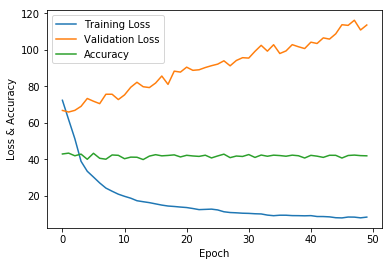

In [49]:
draw_log(log)

## 验证模型

取测试集的第一个batch，输出机器翻译结果和标准答案

In [50]:
for td in test:
    x = td[0].type(itype)
    y = td[1].type(itype)
    
    break
output, attn, outputs, attns, w = evaluate(x, encoder, decoder, bn=1,  max_length=MAX_LENGTH, beam=False)

In [52]:
i = 9
# print(output[i])
# print("\n".join(["{:d}.[{:.4f}] > {:s}".format(j, w[i][j], Chi.indexes2sen(outputs[i][j])) for j in range(3)]))
for i in range(30):
    print("输入<：{}\n输出>：{}\n标准=：{}\n".format(
        Eng.indexes2sen(x[i].cpu().numpy()),
        Chi.indexes2sen(output[i]), 
        Chi.indexes2sen(y[i,:].cpu().numpy())))

输入<：general office of the npc standing committee 11 january 2001
输出>：全国 中国
标准=：全国 人大 常委会 办公厅 2001年1月11日

输入<：this will unavoidably aggravate antagonism between countries in the region .
输出>：这 还 今后 之下 的 的 於 地区 .
标准=：调整 思路 迎接 挑战 --- 俄 启动 新 军事 变革 孟浪 谷亚平

输入<：the two are mutually complementary , and none can be dispensed with .
输出>：双方 两 航天 , 机遇 .
标准=：二者 相辅相成 , 缺一不可 .

输入<：how does the concept of fighting a decisive battle offshore come about ?
输出>：怎样 更新 观念 观念 " 保管员 " ?
标准=：" 决战 境外 " 是 如何 出笼 的 ?

输入<：after repeated votes , the senate overwhelmingly rejected these amendments .
输出>：当地 , 此 后 还 后 , 就 发表 了 .
标准=：参议院 经过 多次 表决 , 以 压倒 多数 否决 了 有关 修正案 .

输入<：parliamentary exchanges are an important component of the two countries relations .
输出>：这 对 两国 关系 的 重要 的 的 .
标准=：议会 交往 是 两国 关系 的 重要 组成部分 .

输入<：chi haotian also recalled with deep feeling past scenes during the years of war .
输出>：迟浩田 对华 两 迟浩田 和 他 对 有关 的 的 .
标准=：迟浩田 还 深情 地 回忆 起 烽火 岁月 的 一 幕 幕 往事 .

输入<：attempts to maintain continuous development of

## 封装工具

In [123]:
def en2cn(sentence, bn=1, debug=False):
    x = torch.LongTensor(langData._toIndex(Eng,sentence,MAX_LENGTH)).type(itype)
    output, attn, outputs, attns, w = evaluate(x, encoder, decoder, bn=bn,  max_length=MAX_LENGTH, debug=debug) 
    print("\n".join(["> [{:.4f}] {:s}".format(w[0][j], Chi.indexes2sen(outputs[0][j])) for j in range(bn)]))

调用测试，当 bn 设置为 1 的时候，beam_search 退化为经典最大值算法

In [120]:
en2cn('enhance understanding and unify thinking .')

> [-5.3089] 代表 认识 , 了解 监督 .


测试输出概率最大的三个翻译

In [121]:
en2cn('enhance understanding and unify thinking .', bn=3)

> [-5.1817] 代表 认识 了解 , 意识 .
> [-5.2232] 代表 深刻 , 了解 监督 .
> [-5.6519] 代表 认识 , 了解 , 意识 .


查看 Beam_search 一步步是如何工作的

In [127]:
en2cn('enhance understanding and unify thinking .', bn=3, debug=True)

---0---
(-0.6119) 代表
(-1.5805) 三
(-1.6381) 加强
---1---
(-1.6041) 代表 认识
(-1.8916) 代表 深刻
(-2.0122) 代表 加强
---2---
(-2.5654) 代表 深刻 ,
(-2.7179) 代表 认识 ,
(-3.0411) 代表 认识 了解
---3---
(-3.6788) 代表 认识 了解 ,
(-3.6985) 代表 深刻 , 了解
(-3.7443) 代表 认识 , 了解
---4---
(-4.0302) 代表 认识 , 了解 ,
(-4.5215) 代表 深刻 , 了解 监督
(-4.8960) 代表 认识 了解 , 意识
---5---
(-5.0025) 代表 深刻 , 了解 监督 .
(-5.1008) 代表 认识 了解 , 意识 .
(-5.4924) 代表 认识 , 了解 , 意识
---6---
(-5.1602) 代表 认识 了解 , 意识 .
(-5.2148) 代表 深刻 , 了解 监督 .
(-5.6374) 代表 认识 , 了解 , 意识 .
---7---
(-5.1793) 代表 认识 了解 , 意识 .
(-5.2222) 代表 深刻 , 了解 监督 .
(-5.6506) 代表 认识 , 了解 , 意识 .
---8---
(-5.1813) 代表 认识 了解 , 意识 .
(-5.2231) 代表 深刻 , 了解 监督 .
(-5.6517) 代表 认识 , 了解 , 意识 .
---9---
(-5.1816) 代表 认识 了解 , 意识 .
(-5.2232) 代表 深刻 , 了解 监督 .
(-5.6519) 代表 认识 , 了解 , 意识 .
---10---
(-5.1817) 代表 认识 了解 , 意识 .
(-5.2232) 代表 深刻 , 了解 监督 .
(-5.6519) 代表 认识 , 了解 , 意识 .
---11---
(-5.1817) 代表 认识 了解 , 意识 .
(-5.2232) 代表 深刻 , 了解 监督 .
(-5.6519) 代表 认识 , 了解 , 意识 .
---12---
(-5.1817) 代表 认识 了解 , 意识 .
(-5.2232) 代表 深刻 , 了解 监督 .
(-5.6519

## 保存网络结构和参数

In [128]:
torch.save(encoder, 'encoder-toy.pkl')
torch.save(decoder, 'decoder-toy.pkl')

/home/vtnil/anaconda3/envs/torch/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/vtnil/anaconda3/envs/torch/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type Decoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# 结束

总结本作业有几个收获：

* 通过重新组织代码，梳理清晰了各部分的逻辑，同时增加了对 pytorch 的熟悉程度；
* 通过使用 SRU，了解了 SRU 与 GRU 的对比情况；
* 通过实现 Beam search 算法，增加了对各种数据类型操作的熟悉程度；
* 中间还遇到一个小插曲，通过对问题的排查，增加了调试训练的能力；
* 通过多参数跑数据集，了解到在这个实验中，注意力网络在中英翻译上的局限；
* 基本实现了作业最初定的目标，「中翻英」以及进一步的实验因为翻译效果不理想，所以索性不再继续；
* 16 词长度，使用本代码大概占用 1G 左右显存；

---

---

---


# Debug

尝试通过替换模块来调试程序

In [8]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        # 第一层Embeddeing
        self.embedding = nn.Embedding(input_size, hidden_size)
        # 第二层GRU，注意GRU中可以定义很多层，主要靠num_layers控制
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first = True, 
                          num_layers = self.n_layers, bidirectional = True)

    def forward(self, input, hidden):
        #前馈过程
        #input尺寸： batch_size, length_seq
        embedded = self.embedding(input)
        #embedded尺寸：batch_size, length_seq, hidden_size
        output = embedded
        output, hidden = self.gru(output, hidden)
        # output尺寸：batch_size, length_seq, hidden_size
        # hidden尺寸：num_layers * directions, batch_size, hidden_size
        return output, hidden

    def initHidden(self, batch_size):
        # 对隐含单元变量全部进行初始化
        #num_layers * num_directions, batch, hidden_size
        result = Variable(torch.zeros(self.n_layers * 2, batch_size, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

# 定义基于注意力的解码器RNN
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.max_length = max_length

        # 词嵌入层
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        
        # 注意力网络（一个前馈神经网络）
        self.attn = nn.Linear(self.hidden_size * (2 * n_layers + 1), self.max_length)
    
        # 注意力机制作用完后的结果映射到后面的层
        self.attn_combine = nn.Linear(self.hidden_size * 3, self.hidden_size)
        
        # dropout操作层
        self.dropout = nn.Dropout(self.dropout_p)
        
        # 定义一个双向GRU，并设置batch_first为True以方便操作
        self.gru = nn.GRU(self.hidden_size, self.hidden_size, bidirectional = True,
                         num_layers = self.n_layers, batch_first = True)
        self.out = nn.Linear(self.hidden_size * 2, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        # 解码器的一步操作
        # input大小：batch_size, length_seq
        embedded = self.embedding(input)
        # embedded大小：batch_size, length_seq, hidden_size
        embedded = embedded[:, 0, :]
        # embedded大小：batch_size, hidden_size
        embedded = self.dropout(embedded)
        
        # 将hidden张量数据转化成batch_size排在第0维的形状
        # hidden大小：direction*n_layer, batch_size, hidden_size
        temp_for_transpose = torch.transpose(hidden, 0, 1).contiguous()
        temp_for_transpose = temp_for_transpose.view(temp_for_transpose.size()[0], -1)
        hidden_attn = temp_for_transpose
        
        # 注意力层的输入
        # hidden_attn大小：batch_size, direction*n_layers*hidden_size
        input_to_attention = torch.cat((embedded, hidden_attn), 1)
        # input_to_attention大小：batch_size, hidden_size * (1 + direction * n_layers)
        
        # 注意力层输出的权重
        attn_weights = F.softmax(self.attn(input_to_attention))
        # attn_weights大小：batch_size, max_length
        
        # 当输入数据不标准的时候，对weights截取必要的一段
        attn_weights = attn_weights[:, : encoder_outputs.size()[1]]
        # attn_weights大小：batch_size, length_seq_of_encoder
        attn_weights = attn_weights.unsqueeze(1)
        # attn_weights大小：batch_size, 1, length_seq 中间的1是为了bmm乘法用的
        
        # 将attention的weights矩阵乘encoder_outputs以计算注意力完的结果
        # encoder_outputs大小：batch_size, seq_length, hidden_size*direction
        attn_applied = torch.bmm(attn_weights, encoder_outputs) 
        # attn_applied大小：batch_size, 1, hidden_size*direction
        # bmm: 两个矩阵相乘。忽略第一个batch纬度，缩并时间维度
        
        # 将输入的词向量与注意力机制作用后的结果拼接成一个大的输入向量
        output = torch.cat((embedded, attn_applied[:,0,:]), 1)
        # output大小：batch_size, hidden_size * (direction + 1)
        
        # 将大输入向量映射为GRU的隐含层
        output = self.attn_combine(output).unsqueeze(1)
        # output大小：batch_size, length_seq, hidden_size
        output = F.relu(output)
        
        # output的结果再dropout
        output = self.dropout(output)

        # 开始解码器GRU的运算
        output, hidden = self.gru(output, hidden)
        
        
        # output大小：batch_size, length_seq, hidden_size * directions
        # hidden大小：n_layers * directions, batch_size, hidden_size
        
        #取出GRU运算最后一步的结果喂给最后一层全链接层
        output = self.out(output[:, -1, :])
        # output大小：batch_size * output_size
        
        # 取logsoftmax，计算输出结果
        output = F.log_softmax(output)
        # output大小：batch_size * output_size
        return output, hidden, attn_weights

    def initHidden(self, batch_size):
        # 初始化解码器隐单元，尺寸为n_layers * directions, batch_size, hidden_size
        result = Variable(torch.zeros(self.n_layers * 2, batch_size, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result
        
    def initInput(self, batch_size):
        return Variable(torch.LongTensor([[Lang.SOS]] * batch_size).type(itype))


In [ ]:
hidden_size = 512
n_layers = 1
core = 'sru'

encoder_t = EncoderRNN(Chi.wordNum(), hidden_size, n_layers = n_layers)
decoder_t = AttnDecoderRNN(hidden_size, Eng.wordNum(), n_layers = n_layers , dropout_p=0.5)
if use_cuda:
    encoder_t.cuda()
    decoder_t.cuda()

log = []
log = training(encoder_t, decoder_t, train, valid, log=log, max_length=MAX_LENGTH, lr=0.0001, n_epoch=20)

In [5]:
import unicodedata
import string
import re
import random

# 读取平行语料库
# 这是人民日报语料库
lines = open('data/chinese.txt', encoding = 'utf-8')
chinese = lines.read().strip().split('\n')
lines = open('data/english.txt', encoding = 'utf-8')
english = lines.read().strip().split('\n')
print(len(chinese))
print(len(english))

# 定义两个特殊符号，分别对应句子头和句子尾
SOS_token = 0
EOS_token = 1


# 定义一个语言类，方便进行自动的建立、词频的统计等
# 在这个对象中，最重要的是两个字典：word2index，index2word
# 故名思议，第一个字典是将word映射到索引，第二个是将索引映射到word
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        # 在语言中添加一个新句子，句子是用空格隔开的一组单词
        # 将单词切分出来，并分别进行处理
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        # 插入一个单词，如果单词已经在字典中，则更新字典中对应单词的频率
        # 同时建立反向索引，可以从单词编号找到单词
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
# 将unicode编码转变为ascii编码
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# 把输入的英文字符串转成小写
def normalizeEngString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

# 对输入的单词对做过滤，保证每句话的单词数不能超过MAX_LENGTH
def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH

# 输入一个句子，输出一个单词对应的编码序列
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


# 和上面的函数功能类似，不同在于输出的序列等长＝MAX_LENGTH
def indexFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    for i in range(MAX_LENGTH - len(indexes)):
        indexes.append(EOS_token)
    return(indexes)

# 从一个词对到下标
def indexFromPair(pair):
    input_variable = indexFromSentence(input_lang, pair[0])
    target_variable = indexFromSentence(output_lang, pair[1])
    return (input_variable, target_variable)

# 从一个列表到句子
def SentenceFromList(lang, lst):
    result = [lang.index2word[i] for i in lst if i != EOS_token]
    if lang.name == 'Chinese':
        result = ' '.join(result)
    else:
        result = ' '.join(result)
    return(result)


# 计算准确度的函数
def rightness(predictions, labels):
    """计算预测错误率的函数，其中predictions是模型给出的一组预测结果，batch_size行num_classes列的矩阵，labels是数据之中的正确答案"""
    pred = torch.max(predictions.data, 1)[1] # 对于任意一行（一个样本）的输出值的第1个维度，求最大，得到每一行的最大元素的下标
    rights = pred.eq(labels.data).sum() #将下标与labels中包含的类别进行比较，并累计得到比较正确的数量
    return rights, len(labels) #返回正确的数量和这一次一共比较了多少元素







# 重新处理数据形成训练数据、校验数据与测试数据，主要是MAX_Length更大了
# 设置句子的最大长度
MAX_LENGTH = 10

#对英文做标准化处理
pairs = [[chi, normalizeEngString(eng)] for chi, eng in zip(chinese, english)]

# 对句子对做过滤，处理掉那些超过MAX_LENGTH长度的句子
input_lang = Lang('Chinese')
output_lang = Lang('English')
pairs = [pair for pair in pairs if filterPair(pair)]
print('有效句子对：', len(pairs))

# 建立两个字典（中文的和英文的）
for pair in pairs:
    input_lang.addSentence(pair[0])
    output_lang.addSentence(pair[1])
print("总单词数:")
print(input_lang.name, input_lang.n_words)
print(output_lang.name, output_lang.n_words)


# 形成训练集，首先，打乱所有句子的顺序
random_idx = np.random.permutation(range(len(pairs)))
pairs = [pairs[i] for i in random_idx]

# 将语言转变为单词的编码构成的序列
pairs = [indexFromPair(pair) for pair in pairs]
    
# 形成训练集、校验集和测试集
valid_size = len(pairs) // 10
if valid_size > 10000:
    valid_size = 10000
pairs = pairs[ : - valid_size]
valid_pairs = pairs[-valid_size : -valid_size // 2]
test_pairs = pairs[- valid_size // 2 :]

# 利用PyTorch的dataset和dataloader对象，将数据加载到加载器里面，并且自动分批

batch_size = 30 #一撮包含30个数据记录，这个数字越大，系统在训练的时候，每一个周期处理的数据就越多，这样处理越快，但总的数据量会减少

print('训练记录：', len(pairs))
print('校验记录：', len(valid_pairs))
print('测试记录：', len(test_pairs))

# 形成训练对列表，用于喂给train_dataset
pairs_X = [pair[0] for pair in pairs]
pairs_Y = [pair[1] for pair in pairs]
valid_X = [pair[0] for pair in valid_pairs]
valid_Y = [pair[1] for pair in valid_pairs]
test_X = [pair[0] for pair in test_pairs]
test_Y = [pair[1] for pair in test_pairs]


# 形成训练集
train_dataset = DataSet.TensorDataset(torch.LongTensor(pairs_X), torch.LongTensor(pairs_Y))
# 形成数据加载器
train_loader = DataSet.DataLoader(train_dataset, batch_size = batch_size, shuffle = True, num_workers=8)


# 校验数据
valid_dataset = DataSet.TensorDataset(torch.LongTensor(valid_X), torch.LongTensor(valid_Y))
valid_loader = DataSet.DataLoader(valid_dataset, batch_size = batch_size, shuffle = True, num_workers=8)

# 测试数据
test_dataset = DataSet.TensorDataset(torch.LongTensor(test_X), torch.LongTensor(test_Y))
test_loader = DataSet.DataLoader(test_dataset, batch_size = batch_size, shuffle = True, num_workers = 8)

100000
100000
有效句子对： 1836
总单词数:
Chinese 3324
English 3011
训练记录： 1653
校验记录： 91
测试记录： 92


In [14]:

# 计算准确度的函数
def rightness(predictions, labels):
    """计算预测错误率的函数，其中predictions是模型给出的一组预测结果，batch_size行num_classes列的矩阵，labels是数据之中的正确答案"""
    pred = torch.max(predictions.data, 1)[1] # 对于任意一行（一个样本）的输出值的第1个维度，求最大，得到每一行的最大元素的下标
    rights = pred.eq(labels.data).sum() #将下标与labels中包含的类别进行比较，并累计得到比较正确的数量
    return rights, len(labels) #返回正确的数量和这一次一共比较了多少元素

# 定义两个特殊符号，分别对应句子头和句子尾
SOS_token = 0
EOS_token = 1

#定义网络架构
hidden_size = 512
max_length = MAX_LENGTH
n_layers = 1
core='sru'


encoder = EncoderRNN(Chi.wordNum(), hidden_size, n_layers = n_layers)
decoder = AttnDecoderRNN(hidden_size, Eng.wordNum(), dropout_p=0.5,
                         max_length = max_length, n_layers = n_layers)

# encoder = Encoder(input_lang.n_words, hidden_size, n_layers = n_layers, core=core)
# decoder = Decoder(hidden_size, output_lang.n_words, n_layers = n_layers , attn_size=MAX_LENGTH, dropout_p=0.2, core=core)

if use_cuda:
    encoder.cuda()
    decoder.cuda()


print_loss_total = 0  # Reset every print_every
learning_rate = 0.0001
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)

criterion = nn.NLLLoss()
#criterion = Batch_NLLLoss
teacher_forcing_ratio = 0.5

num_epoch = 100

# 开始训练周期循环
plot_losses = []
for epoch in range(num_epoch):
    # 将解码器置于训练状态，让dropout工作
    decoder.train()
    print_loss_total = 0
    # 对训练数据进行循环
    for data in train:
        input_variable = Variable(data[0]).cuda() if use_cuda else Variable(data[0])
        # input_variable的大小：batch_size, length_seq
        target_variable = Variable(data[1]).cuda() if use_cuda else Variable(data[1])
        # target_variable的大小：batch_size, length_seq
        
        #清空梯度
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        
        encoder_hidden = encoder.initHidden(data[0].size()[0])

        loss = 0

        #编码器开始工作
        encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)
        # encoder_outputs的大小：batch_size, length_seq, hidden_size*direction
        # encoder_hidden的大小：direction*n_layer, batch_size, hidden_size

        # 解码器开始工作
        decoder_input = Variable(torch.LongTensor([[SOS_token]] * target_variable.size()[0]))
        # decoder_input大小：batch_size, length_seq
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input

        # 将编码器的隐含层单元取值作为编码的结果传递给解码器
        decoder_hidden = encoder_hidden
        # decoder_hidden大小：direction*n_layer, batch_size, hidden_size

        # 同时按照两种方式训练解码器：用教师监督的信息作为下一时刻的输入和不用监督的信息，用自己预测结果作为下一时刻的输入
        use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
        if use_teacher_forcing:
            # 用监督信息作为下一时刻解码器的输入
            # 开始时间不得循环
            for di in range(MAX_LENGTH):
                # 输入给解码器的信息包括输入的单词decoder_input, 解码器上一时刻的因曾单元状态，
                # 编码器各个时间步的输出结果
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
                #decoder_ouput大小：batch_size, output_size
                #计算损失函数，得到下一时刻的解码器的输入
                loss += criterion(decoder_output, target_variable[:, di])
                decoder_input = target_variable[:, di].unsqueeze(1)  # Teacher forcing
                # decoder_input大小：batch_size, length_seq
        else:
            # 没有教师监督，用解码器自己的预测作为下一时刻的输入

            # 对时间步进行循环
            for di in range(MAX_LENGTH):
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
                #decoder_ouput大小：batch_size, output_size(vocab_size)
                # 获取解码器的预测结果，并用它来作为下一时刻的输入
                topv, topi = decoder_output.data.topk(1, dim = 1)
                #topi 尺寸：batch_size, k
                ni = topi[:, 0]

                decoder_input = Variable(ni.unsqueeze(1))
                # decoder_input大小：batch_size, length_seq
                decoder_input = decoder_input.cuda() if use_cuda else decoder_input

                # 计算损失函数
                loss += criterion(decoder_output, target_variable[:, di])
        
        
        
        # 反向传播开始
        loss.backward()
        loss = loss.cpu() if use_cuda else loss
        # 开始梯度下降
        encoder_optimizer.step()
        decoder_optimizer.step()
        print_loss_total += loss.data.numpy()[0]

    print_loss_avg = print_loss_total / len(train)
        
    valid_loss = 0
    rights = []
    # 将解码器的training设置为False，以便关闭dropout
    decoder.eval()
    
    #对所有的校验数据做循环
    for data in valid:
        input_variable = Variable(data[0]).cuda() if use_cuda else Variable(data[0])
        # input_variable的大小：batch_size, length_seq
        target_variable = Variable(data[1]).cuda() if use_cuda else Variable(data[1])
        # target_variable的大小：batch_size, length_seq

        encoder_hidden = encoder.initHidden(data[0].size()[0])

        loss = 0
        encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)
        # encoder_outputs的大小：batch_size, length_seq, hidden_size*direction
        # encoder_hidden的大小：direction*n_layer, batch_size, hidden_size

        # decoder_input大小：batch_size, length_seq
        decoder_input = Variable(torch.LongTensor([[SOS_token]] * target_variable.size()[0]))
        # decoder_input大小：batch_size, length_seq
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input

        decoder_hidden = encoder_hidden
        # decoder_hidden大小：direction*n_layer, batch_size, hidden_size

        # 开始每一步的预测
        for di in range(MAX_LENGTH):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            #decoder_ouput大小：batch_size, output_size(vocab_size)
            topv, topi = decoder_output.data.topk(1, dim = 1)
            #topi 尺寸：batch_size, k
            ni = topi[:, 0]

            decoder_input = Variable(ni.unsqueeze(1))
            # decoder_input大小：batch_size, length_seq
            decoder_input = decoder_input.cuda() if use_cuda else decoder_input
            right = rightness(decoder_output, target_variable[:, di])
            rights.append(right)
            loss += criterion(decoder_output, target_variable[:, di])
        loss = loss.cpu() if use_cuda else loss
        valid_loss += loss.data.numpy()[0]
    # 计算平均损失、准确率等指标并打印输出
    right_ratio = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])
    print('进程：%d%% 训练损失：%.4f，校验损失：%.4f，词正确率：%.2f%%' % (epoch * 1.0 / num_epoch * 100, 
                                                    print_loss_avg,
                                                    valid_loss / len(valid),
                                                    100.0 * right_ratio))
    plot_losses.append([print_loss_avg, valid_loss / len(valid), right_ratio])

进程：0% 训练损失：58.4112，校验损失：49.4798，词正确率：31.40%
进程：1% 训练损失：47.3585，校验损失：48.5506，词正确率：32.67%
进程：2% 训练损失：45.3690，校验损失：48.9167，词正确率：32.56%
进程：3% 训练损失：44.5954，校验损失：48.0342，词正确率：32.91%
进程：4% 训练损失：43.6130，校验损失：47.8174，词正确率：32.79%
进程：5% 训练损失：42.4692，校验损失：47.9798，词正确率：33.14%
进程：6% 训练损失：41.4694，校验损失：47.6592，词正确率：33.26%
进程：7% 训练损失：40.2288，校验损失：47.8592，词正确率：33.60%
进程：8% 训练损失：39.2850，校验损失：47.9711，词正确率：34.88%
进程：9% 训练损失：38.0226，校验损失：48.6809，词正确率：32.33%
进程：10% 训练损失：37.0786，校验损失：48.2187，词正确率：33.84%
进程：11% 训练损失：35.8032，校验损失：49.0991，词正确率：30.93%
进程：12% 训练损失：34.8677，校验损失：48.8506，词正确率：32.91%
进程：13% 训练损失：34.0522，校验损失：49.0518，词正确率：33.02%
进程：14% 训练损失：32.7393，校验损失：49.6140，词正确率：31.28%
进程：15% 训练损失：31.7716，校验损失：49.9875，词正确率：32.91%


Process Process-620:
Process Process-619:
Process Process-617:
Process Process-622:
Traceback (most recent call last):
  File "/home/vtnil/anaconda3/envs/torch/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Process Process-621:
Traceback (most recent call last):
Process Process-623:
Process Process-618:
Traceback (most recent call last):
Process Process-624:
  File "/home/vtnil/anaconda3/envs/torch/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/vtnil/anaconda3/envs/torch/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/vtnil/anaconda3/envs/torch/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/vtnil/anaconda3/envs/torch/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most rec

KeyboardInterrupt: 